# 6 Time Series Classification

ECG classification: ischemic vs non-ischemic

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import warnings
import pickle
warnings.filterwarnings('ignore')

# tslearn
try:
    from tslearn.neighbors import KNeighborsTimeSeriesClassifier
    from tslearn.utils import to_time_series_dataset
    from tslearn.preprocessing import TimeSeriesScalerMeanVariance
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tslearn"])
    from tslearn.neighbors import KNeighborsTimeSeriesClassifier
    from tslearn.utils import to_time_series_dataset
    from tslearn.preprocessing import TimeSeriesScalerMeanVariance

try:
    import xgboost as xgb
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)
base_path = Path.cwd()
if base_path.name == 'code':
    base_path = base_path.parent
data_path = base_path / 'Data'
code_path = base_path / 'code'
plots_path = base_path / 'plots'
plots_path.mkdir(exist_ok=True)

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")
print(f"Plots path: {plots_path}")

# Load preprocessed data
preprocessed_file = data_path / 'preprocessed_time_series.pkl'
print(f"\nLoading preprocessed time series data from: {preprocessed_file}")

with open(preprocessed_file, 'rb') as f:
    preprocessed_data = pickle.load(f)

# Extract original-length time series
subject_ids = preprocessed_data['subject_ids']
X_preprocessed_original = preprocessed_data['preprocessed_original_length']  # Variable lengths

# Convert to dict
ecg_time_series = {sid: ts for sid, ts in zip(subject_ids, X_preprocessed_original)}

print(f"\nLoaded preprocessed time series data:")
print(f"  - Number of subjects: {len(ecg_time_series):,}")
print(f"  - Preprocessing steps: {', '.join(preprocessed_data['metadata']['preprocessing_steps'])}")

print(f"\nTotal patients with ECG time series: {len(ecg_time_series):,}")
if ecg_time_series:
    sample_subject = list(ecg_time_series.keys())[0]
    sample_ts = ecg_time_series[sample_subject]
    print(f"\nExample time series for subject {sample_subject}:")
    print(f"  Length: {len(sample_ts):,} samples")
    print(f"  First 10 values: {sample_ts[:10]}")
    print(f"  Mean: {np.mean(sample_ts):.4f}, Std: {np.std(sample_ts):.4f}")

Working directory: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data
Plots path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/plots

Loading preprocessed time series data from: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/preprocessed_time_series.pkl

Loaded preprocessed time series data:
  - Number of subjects: 1,786
  - Preprocessing steps: offset_translation_removal, amplitude_scaling_z_normalization, linear_trend_removal, noise_filtering_moving_average

Total patients with ECG time series: 1,786

Example time series for subject 10000980:
  Length: 5,000 samples
  First 10 values: [-0.10123974877784615 -0.0028592433472473117 0.029930863082936226
 -0.01926702923739937 -0.06846492155773495 -0.06847001462775908
 -0.019282308447471704 0.046302997482919474 0.06269550416299918
 0.046292811342871

## Merge Data

In [8]:
diagnoses_file = data_path / "heart_diagnoses_1.csv"
icds = {
    "I20", "I21", "I22", "I24", "I25",
    "I30", "I31", "I33",
    "I34", "I35", "I36",
    "I40", "I42",
    "I44", "I45", "I46", "I47", "I48", "I49",
    "I50"
}

class1 = {"I20", "I21", "I22", "I24", "I25"}

def compute_ischemic_label(code_set: set) -> int:
    ischemic = len(code_set & class1) > 0
    return 1 if ischemic else 0

diag = pd.read_csv(diagnoses_file)
diag["subject_id"] = diag["subject_id"].astype(str).str.strip()
diag["icd_code"] = (
    diag["icd_code"]
    .astype(str)
    .str.strip()
    .str.upper()
    .replace({"": np.nan, "NAN": np.nan})
)

diag_valid = diag[diag["icd_code"].isin(icds)].copy()

if diag_valid.empty:
    raise ValueError("Problems with the format of the codes")
subject_codes = (
    diag_valid.groupby("subject_id")["icd_code"].unique().reset_index(name="icd_codes_list")
)
subject_codes["icd_codes_set"] = subject_codes["icd_codes_list"].apply(set)

subject_codes["label_ischemic"] = subject_codes["icd_codes_set"].apply(compute_ischemic_label)
patient_labels = subject_codes[["subject_id", "label_ischemic"]].copy()
patient_labels["subject_id"] = patient_labels["subject_id"].astype(int)

print(f"Total patients with labels: {len(patient_labels)}")
print(f"\nLabel distribution:")
print(patient_labels["label_ischemic"].value_counts())
print(f"\nLabel distribution (%):")
print(patient_labels["label_ischemic"].value_counts(normalize=True) * 100)

Total patients with labels: 4392

Label distribution:
label_ischemic
0    2374
1    2018
Name: count, dtype: int64

Label distribution (%):
label_ischemic
0    54.052823
1    45.947177
Name: proportion, dtype: float64


In [9]:
# Merge time series with labels
ts_subjects = set(ecg_time_series.keys())
label_subjects = set(patient_labels["subject_id"].values)
common_subjects = ts_subjects & label_subjects

print(f"Patients with time series: {len(ts_subjects):,}")
print(f"Patients with labels: {len(label_subjects):,}")
print(f"Patients with both: {len(common_subjects):,}")

# Filter common subjects
filtered_labels = patient_labels[patient_labels["subject_id"].isin(common_subjects)].copy()
filtered_labels = filtered_labels.sort_values("subject_id").reset_index(drop=True)

# Create aligned arrays
X_raw = []  # Raw time series
y = []      # Labels
subject_ids = []

for subject_id in filtered_labels["subject_id"].values:
    X_raw.append(ecg_time_series[subject_id])
    y.append(filtered_labels[filtered_labels["subject_id"] == subject_id]["label_ischemic"].values[0])
    subject_ids.append(subject_id)

X_raw = np.array(X_raw, dtype=object)
y = np.array(y)
subject_ids = np.array(subject_ids)

print(f"\nFinal dataset:")
print(f"  Number of samples: {len(X_raw):,}")
print(f"  Label distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"    Class {label}: {count:,} ({count/len(y)*100:.1f}%)")
ts_lengths = [len(ts) for ts in X_raw]
print(f"\nTime series length statistics:")
print(f"  Min: {min(ts_lengths):,}")
print(f"  Max: {max(ts_lengths):,}")
print(f"  Mean: {np.mean(ts_lengths):.1f}")
print(f"  Median: {np.median(ts_lengths):.1f}")
print(f"  Std: {np.std(ts_lengths):.1f}")

Patients with time series: 1,786
Patients with labels: 4,392
Patients with both: 1,184

Final dataset:
  Number of samples: 1,184
  Label distribution:
    Class 0: 609 (51.4%)
    Class 1: 575 (48.6%)

Time series length statistics:
  Min: 5,000
  Max: 5,000
  Mean: 5000.0
  Median: 5000.0
  Std: 0.0


## Feature Extraction using Approximation Methods

Implement PAA (Piecewise Aggregate Approximation), SAX (Symbolic Aggregate Approximation), and DFT (Discrete Fourier Transform) for feature extraction.

In [10]:
def paa(time_series, n_segments):
    """PAA: average segments of time series."""
    ts = np.array(time_series)
    n = len(ts)
    
    if n_segments >= n:
        return ts
    

    segment_size = n / n_segments
    
    paa_values = []
    for i in range(n_segments):
        start = int(i * segment_size)
        end = int((i + 1) * segment_size)
        if i == n_segments - 1:
            end = n
        paa_values.append(np.mean(ts[start:end]))
    
    return np.array(paa_values)

def sax(time_series, n_segments, alphabet_size=4):
    """SAX: PAA then convert to symbols."""
    # Z-normalize
    ts = np.array(time_series)
    if np.std(ts) == 0:
        ts_norm = ts - np.mean(ts)
    else:
        ts_norm = (ts - np.mean(ts)) / np.std(ts)
    

    paa_values = paa(ts_norm, n_segments)
    
    from scipy.stats import norm
    breakpoints = []
    for i in range(1, alphabet_size):
        breakpoints.append(norm.ppf(i / alphabet_size))
    sax_symbols = []
    for val in paa_values:
        symbol = 0
        for i, bp in enumerate(breakpoints):
            if val > bp:
                symbol = i + 1
        sax_symbols.append(symbol)
    
    return np.array(sax_symbols)

def dft_features(time_series, n_coefficients=20):
    ts = np.array(time_series)
    fft_vals = fft(ts)
    n_coeffs = min(n_coefficients, len(fft_vals) // 2)
    dft_features = np.abs(fft_vals[:n_coeffs])
    dft_features = dft_features / len(ts)
    
    return dft_features

sample_ts = X_raw[0]
print(f"Sample time series length: {len(sample_ts)}")

paa_features = paa(sample_ts, n_segments=20)
print(f"PAA: shape {paa_features.shape}")

sax_features = sax(sample_ts, n_segments=20, alphabet_size=4)
print(f"SAX: shape {sax_features.shape}")

dft_features_sample = dft_features(sample_ts, n_coefficients=20)
print(f"DFT: shape {dft_features_sample.shape}")

Sample time series length: 5000
PAA: shape (20,)
SAX: shape (20,)
DFT: shape (20,)


In [ ]:
print("Extracting features...")
n_paa_segments = 30
n_sax_segments = 30
sax_alphabet_size = 4
n_dft_coefficients = 30

X_paa = []
X_sax = []
X_dft = []

for i, ts in enumerate(X_raw):
    X_paa.append(paa(ts, n_paa_segments))
    X_sax.append(sax(ts, n_sax_segments, sax_alphabet_size))
    X_dft.append(dft_features(ts, n_dft_coefficients))
    
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{len(X_raw)} time series...")

# Convert to arrays
X_paa = np.array(X_paa)
X_sax = np.array(X_sax)
X_dft = np.array(X_dft)

# Combine all features for LR and XGBoost
X_features = np.hstack([X_paa, X_sax, X_dft])

print(f"\nFeature extraction complete!")
print(f"  PAA features shape: {X_paa.shape}")
print(f"  SAX features shape: {X_sax.shape}")
print(f"  DFT features shape: {X_dft.shape}")
print(f"  Combined features shape: {X_features.shape}")

Extracting features...
  Processed 200/1184 time series...
  Processed 400/1184 time series...
  Processed 600/1184 time series...
  Processed 800/1184 time series...
  Processed 1000/1184 time series...

Feature extraction complete!
  PAA features shape: (1184, 30)
  SAX features shape: (1184, 30)
  DFT features shape: (1184, 30)
  Combined features shape: (1184, 90)


## Train-Test Split

In [12]:
X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)
train_indices, test_indices = train_test_split(
    np.arange(len(X_raw)), test_size=0.2, random_state=42, stratify=y
)

X_train_raw = [X_raw[i] for i in train_indices]
X_test_raw = [X_raw[i] for i in test_indices]
y_train_ts = y[train_indices]
y_test_ts = y[test_indices]

print("Train-Test Split Complete!")
print(f"\nTraining set:")
print(f"  Samples: {len(X_train_features):,}")
print(f"  Class distribution: {np.bincount(y_train)}")
print(f"  Class distribution (%): {np.bincount(y_train) / len(y_train) * 100}")

print(f"\nTest set:")
print(f"  Samples: {len(X_test_features):,}")
print(f"  Class distribution: {np.bincount(y_test)}")
print(f"  Class distribution (%): {np.bincount(y_test) / len(y_test) * 100}")

scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

print(f"\nFeatures standardized for LR and XGBoost models.")

Train-Test Split Complete!

Training set:
  Samples: 947
  Class distribution: [487 460]
  Class distribution (%): [51.42555438 48.57444562]

Test set:
  Samples: 237
  Class distribution: [122 115]
  Class distribution (%): [51.47679325 48.52320675]

Features standardized for LR and XGBoost models.


## Model Training

### KNN with DTW Distance

In [22]:
# Parameters
# target_length: DTW is O(n²), keep low for speed
target_length = 20  # 20→30 = 2.25x slower, minimal quality gain
# max_train_samples: More data = better model, but quadratic DTW cost
max_train_samples = 300  # 200→300 = 1.5x train, ~2.25x DTW time
# max_test_samples: Only affects eval time, safe to increase
max_test_samples = 120  # 50→120 = 2.4x eval time, better reliability

def downsample_time_series_stratified(time_series, target_length, random_seed=None):
    ts = np.array(time_series)
    n = len(ts)
    
    if n <= target_length:
        return ts
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_segments = target_length
    segment_size = n / n_segments
    
    sampled_indices = []
    for i in range(n_segments):
        start = int(i * segment_size)
        end = int((i + 1) * segment_size)
        if i == n_segments - 1:
            end = n
        
        if end > start:
            idx = np.random.randint(start, end)
            sampled_indices.append(idx)
    
    sampled_indices = sorted(sampled_indices)
    
    return ts[sampled_indices]

original_length = len(X_train_raw[0])
original_train_size = len(X_train_raw)
original_test_size = len(X_test_raw)

X_train_downsampled = [downsample_time_series_stratified(ts, target_length=target_length, random_seed=42+i) 
                       for i, ts in enumerate(X_train_raw)]
X_test_downsampled = [downsample_time_series_stratified(ts, target_length=target_length, random_seed=1000+i) 
                      for i, ts in enumerate(X_test_raw)]

np.random.seed(42)
train_indices = np.random.choice(len(X_train_downsampled), 
                                size=min(max_train_samples, len(X_train_downsampled)), 
                                replace=False)
test_indices = np.random.choice(len(X_test_downsampled), 
                               size=min(max_test_samples, len(X_test_downsampled)), 
                               replace=False)

X_train_downsampled = [X_train_downsampled[i] for i in train_indices]
X_test_downsampled = [X_test_downsampled[i] for i in test_indices]
y_train_ts_reduced = y_train_ts[train_indices]
y_test_ts_reduced = y_test_ts[test_indices]

X_train_padded = np.array(X_train_downsampled)
X_test_padded = np.array(X_test_downsampled)

print(f"Training: {X_train_padded.shape}, Test: {X_test_padded.shape}")
X_train_ts = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)
X_test_ts = X_test_padded.reshape(X_test_padded.shape[0], X_test_padded.shape[1], 1)

print(f"Training KNN with DTW...")
print(f"  Training samples: {X_train_ts.shape}")
print(f"  Test samples: {X_test_ts.shape}")

k_values = [3, 5, 7]
knn_models = {}
knn_predictions = {}

for k in k_values:
    print(f"\nTraining KNN with k={k}...")
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw", n_jobs=-1)
    knn.fit(X_train_ts, y_train_ts_reduced)
    knn_models[k] = knn
    
    y_pred_knn = knn.predict(X_test_ts)
    knn_predictions[k] = y_pred_knn
    
    f1 = f1_score(y_test_ts_reduced, y_pred_knn)
    acc = accuracy_score(y_test_ts_reduced, y_pred_knn)
    print(f"  k={k}: Accuracy={acc:.4f}, F1={f1:.4f}")

best_k = max(k_values, key=lambda k: f1_score(y_test_ts_reduced, knn_predictions[k]))
print(f"\nBest k: {best_k}")

knn_best = knn_models[best_k]
y_pred_knn_final = knn_predictions[best_k]

Training: (300, 20), Test: (120, 20)
Training KNN with DTW...
  Training samples: (300, 20, 1)
  Test samples: (120, 20, 1)

Training KNN with k=3...
  k=3: Accuracy=0.4333, F1=0.4333

Training KNN with k=5...
  k=5: Accuracy=0.4500, F1=0.4107

Training KNN with k=7...
  k=7: Accuracy=0.4417, F1=0.4174

Best k: 3


### Logistic Regression

In [23]:
print("Training Logistic Regression...")

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

lr_model.fit(X_train_features_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_features_scaled)
y_pred_lr_proba = lr_model.predict_proba(X_test_features_scaled)[:, 1]

print(f"  Training accuracy: {lr_model.score(X_train_features_scaled, y_train):.4f}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"  Test F1: {f1_score(y_test, y_pred_lr):.4f}")

Training Logistic Regression...
  Training accuracy: 0.6051
  Test accuracy: 0.5148
  Test F1: 0.5188


### XGBoost

In [24]:
print("Training XGBoost...")

pos_count = np.sum(y_train == 1)
neg_count = np.sum(y_train == 0)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(
    X_train_features_scaled, y_train,
    eval_set=[(X_test_features_scaled, y_test)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test_features_scaled)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_features_scaled)[:, 1]

print(f"  Training accuracy: {xgb_model.score(X_train_features_scaled, y_train):.4f}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"  Test F1: {f1_score(y_test, y_pred_xgb):.4f}")

Training XGBoost...
  Training accuracy: 0.9989
  Test accuracy: 0.5021
  Test F1: 0.5000


## Model Evaluation

In [25]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name=""):
    """Evaluate a classification model and return metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    if 'roc_auc' in metrics:
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"\n  Confusion Matrix:")
    print(f"{cm}")
    
    return metrics, cm

print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

knn_metrics, knn_cm = evaluate_model(
    y_test_ts_reduced, y_pred_knn_final,
    model_name="KNN with DTW (k={})".format(best_k)
)

lr_metrics, lr_cm = evaluate_model(
    y_test, y_pred_lr, y_pred_lr_proba,
    model_name="Logistic Regression"
)

xgb_metrics, xgb_cm = evaluate_model(
    y_test, y_pred_xgb, y_pred_xgb_proba,
    model_name="XGBoost"
)
results = {
    'KNN (DTW)': knn_metrics,
    'Logistic Regression': lr_metrics,
    'XGBoost': xgb_metrics
}

confusion_matrices = {
    'KNN (DTW)': knn_cm,
    'Logistic Regression': lr_cm,
    'XGBoost': xgb_cm
}

MODEL EVALUATION

KNN with DTW (k=3) Results:
  Accuracy:  0.4333
  Precision: 0.4815
  Recall:    0.3939
  F1-Score:  0.4333

  Confusion Matrix:
[[26 28]
 [40 26]]

Logistic Regression Results:
  Accuracy:  0.5148
  Precision: 0.5000
  Recall:    0.5391
  F1-Score:  0.5188
  ROC-AUC:   0.5253

  Confusion Matrix:
[[60 62]
 [53 62]]

XGBoost Results:
  Accuracy:  0.5021
  Precision: 0.4876
  Recall:    0.5130
  F1-Score:  0.5000
  ROC-AUC:   0.5089

  Confusion Matrix:
[[60 62]
 [56 59]]


## Comparison and Visualization

In [26]:
comparison_df = pd.DataFrame(results).T
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(comparison_df.round(4))

best_model_name = comparison_df['f1'].idxmax()
best_f1 = comparison_df['f1'].max()
print(f"\nBest model: {best_model_name} (F1 = {best_f1:.4f})")


MODEL COMPARISON
                     accuracy  precision  recall      f1  roc_auc
KNN (DTW)              0.4333     0.4815  0.3939  0.4333      NaN
Logistic Regression    0.5148     0.5000  0.5391  0.5188   0.5253
XGBoost                0.5021     0.4876  0.5130  0.5000   0.5089

Best model: Logistic Regression (F1 = 0.5188)


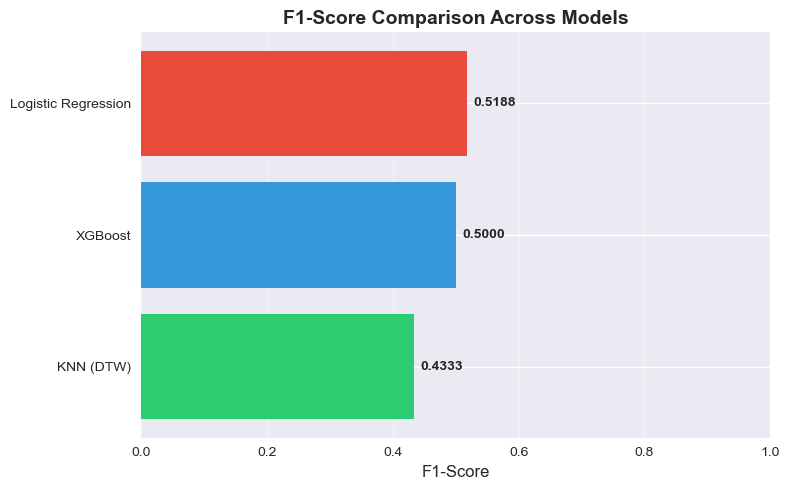

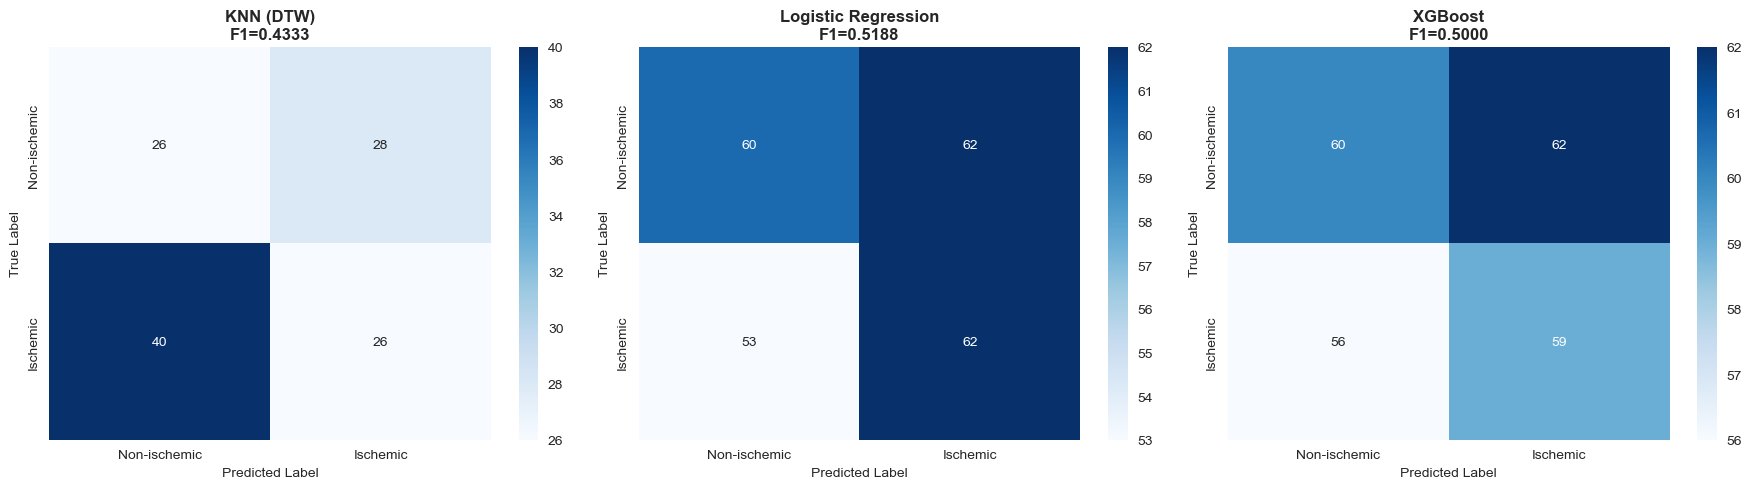

In [27]:
fig1, ax1 = plt.subplots(figsize=(8, 5))
f1_scores = comparison_df['f1'].sort_values(ascending=True)
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax1.barh(f1_scores.index, f1_scores.values, color=colors[:len(f1_scores)])
ax1.set_xlabel('F1-Score', fontsize=12)
ax1.set_title('F1-Score Comparison Across Models', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1])
ax1.grid(axis='x', alpha=0.3)

for i, (idx, val) in enumerate(f1_scores.items()):
    ax1.text(val + 0.01, i, f'{val:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(plots_path / '6.tsc_f1_scores.png', dpi=300, bbox_inches='tight')
plt.show()

fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes2[idx],
                xticklabels=['Non-ischemic', 'Ischemic'],
                yticklabels=['Non-ischemic', 'Ischemic'])
    axes2[idx].set_title(f'{model_name}\nF1={results[model_name]["f1"]:.4f}', 
                        fontsize=12, fontweight='bold')
    axes2[idx].set_ylabel('True Label', fontsize=10)
    axes2[idx].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.savefig(plots_path / '6.tsc_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

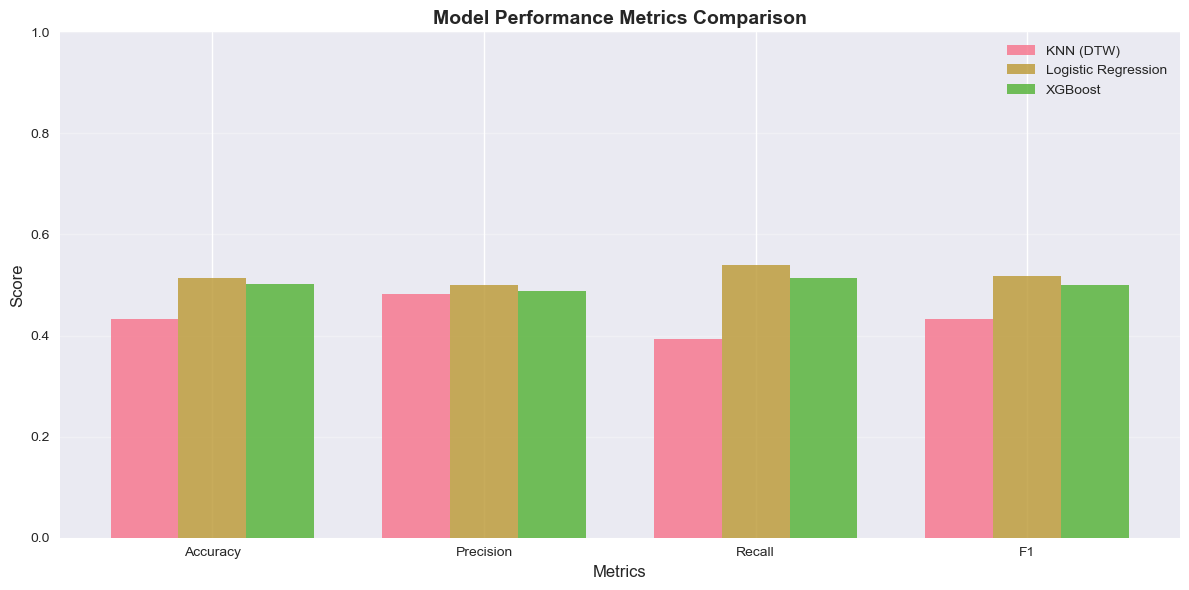

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, model_name in enumerate(comparison_df.index):
    values = [comparison_df.loc[model_name, metric] for metric in metrics_to_plot]
    offset = (i - 1) * width
    ax.bar(x + offset, values, width, label=model_name, alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_to_plot])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(plots_path / '6.tsc_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

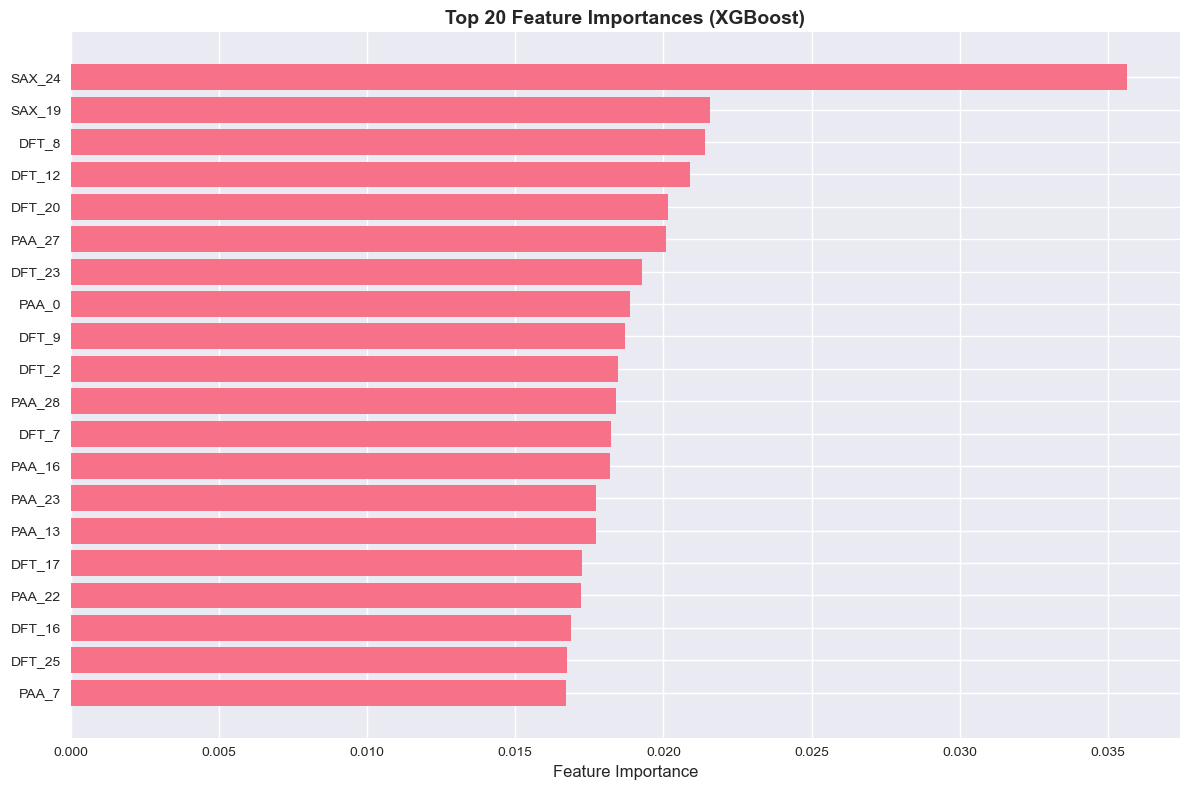


Top 10 Most Important Features:
  1. SAX_24: 0.0357
  2. SAX_19: 0.0216
  3. DFT_8: 0.0214
  4. DFT_12: 0.0209
  5. DFT_20: 0.0201
  6. PAA_27: 0.0201
  7. DFT_23: 0.0193
  8. PAA_0: 0.0189
  9. DFT_9: 0.0187
  10. DFT_2: 0.0185


In [29]:
if hasattr(xgb_model, 'feature_importances_'):
    feature_names = (
        [f'PAA_{i}' for i in range(n_paa_segments)] +
        [f'SAX_{i}' for i in range(n_sax_segments)] +
        [f'DFT_{i}' for i in range(n_dft_coefficients)]
    )
    
    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)[::-1][:20]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(range(len(indices)), importances[indices], align='center')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Feature Importance', fontsize=12)
    ax.set_title('Top 20 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig(plots_path / '6.tsc_feature_importances.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    for i, idx in enumerate(indices[:10]):
        print(f"  {i+1}. {feature_names[idx]}: {importances[idx]:.4f}")